# Imports

In [ ]:
from torchvision import datasets, transforms
import torch
import requests
import torch.nn as nn
from safetensors.torch import load
from datasets import load_dataset
from transformers import GPTNeoXForCausalLM, AutoTokenizer
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import roc_curve
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150

In [ ]:
%pip install adversarial-robustness-toolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.6 MB/s eta 0:00:00


In [ ]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load up FashionMNIST data with the transform
ds_test = datasets.FashionMNIST(root=".", train=False, download=True, transform=transform)
data_classes = ds_test.classes

100%|██████████| 26.4M/26.4M [00:01<00:00, 20.3MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 306kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.56MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 16.9MB/s]


In [ ]:
# Define and download model
class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128) # After two pooling layers (28x28 -> 14x14 -> 7x7)
        self.fc2 = nn.Linear(128, 10) # 10 classes in FashionMNIST

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7) # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = BasicCNN()

In [ ]:
# Load model
download_path = "https://huggingface.co/iamgroot42/fashionmnist_cnn2/resolve/main/basic_cnn.safetensors"
response = requests.get(download_path)
data = response.content

state_dict = load(data)
model.load_state_dict(state_dict)
model.to(device)
model.eval()

BasicCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

# Problem 1

You will use the IBM ART Python library to generate adversarial examples using the Carlini-Wagner attack for L2 norm. The library is available at: [https://github.com/Trusted-AI/adversarial-robustness-toolbox](https://github.com/Trusted-AI/adversarial-robustness-toolbox)

In [ ]:
torch.manual_seed(2025)

# Get 100 samples from the processed ds_test
num_examples_wanted, so_far = 50, 0
loader = torch.utils.data.DataLoader(ds_test, batch_size=64, shuffle=True)
x_test, y_test = [], []
with torch.no_grad():
  for batch in loader:
      x, y = batch
      x, y = x.to(device), y.to(device)
      y_probs = nn.functional.softmax(model(x), dim=1)
      wanted = (y_probs.argmax(1) == y)
      x_test.append(x[wanted])
      y_test.append(y[wanted])
      so_far += wanted.sum()
      if so_far >= num_examples_wanted:
        break

x_test = torch.cat(x_test)[:num_examples_wanted].cpu()
y_test = torch.cat(y_test)[:num_examples_wanted].cpu()

In [ ]:
print(x_test.shape, y_test.shape)

torch.Size([50, 1, 28, 28]) torch.Size([50])


#### (a) Run the Carlini-Wagner evasion attack for the 50 images provided (the prediction is correct for these images). For each image, compute the perturbation $\epsilon$ as the $L_2$ norm of the difference between the adversarial example and the original image.

Bin the perturbations for the 50 images and generate a histogram of attack success (i.e., percentage of misclasifications) as a function of  perturbation  for constant $c=1e-3$. You can use a learning rate of $0.1$ and train the attack for 50 epochs. Discuss your observations.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from art.estimators.classification import PyTorchClassifier
from art.attacks.evasion import CarliniL2Method, ProjectedGradientDescent, HopSkipJump
from tqdm import tqdm

Generating adversarial examples with c = 0.001


C&W L_2:   0%|          | 0/50 [00:00<?, ?it/s]


=== Run attack with c=0.001: ===
Attack Success Rate (ASR): 0.4
Mean perturbation ε: 0.21485067903995514
Std perturbation ε: 0.30020564794540405


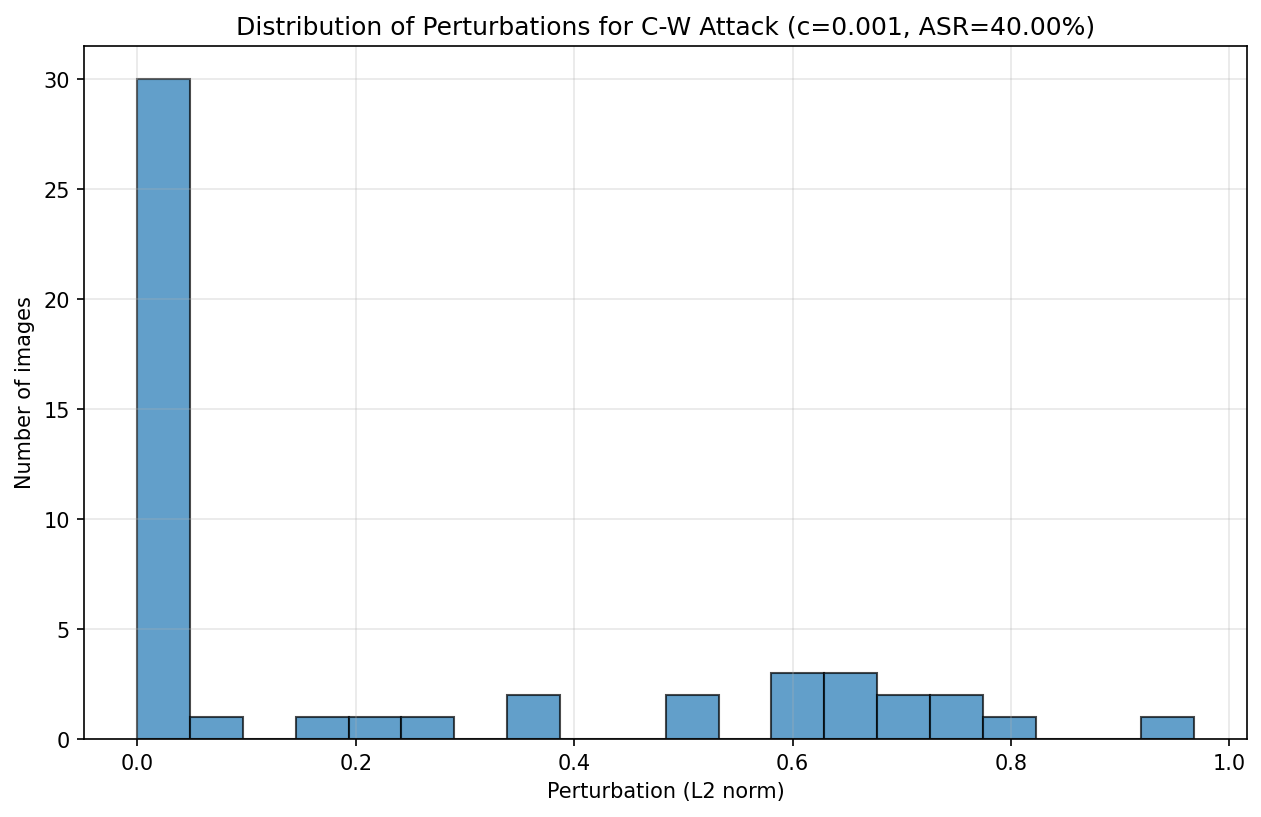

In [ ]:
### attack 50 images using cw
def run_cw_attack(model, x_test, y_test, c=0.001, learning_rate=0.1, max_iter=50):
    """
    Run Carlini-Wagner L2 attack on test images
    """
    # Create ART classifier wrapper
    classifier = PyTorchClassifier(
        model=model,
        loss=nn.CrossEntropyLoss(),
        input_shape=(1, 28, 28),
        nb_classes=10,
        clip_values=(-1.0, 1.0),
        # need CUDA
        device_type='cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
    )

    # Initialize Carlini-Wagner L2 attack
    cw_attack = CarliniL2Method(
        classifier = classifier,
        confidence = c,
        learning_rate = learning_rate,
        max_iter = max_iter,
        binary_search_steps = 5,
        initial_const = 0.01,
        batch_size = 1
    )

    test_np_x = x_test.numpy()
    test_np_y = y_test.numpy()

    ## adversarial examples
    print("Generating adversarial examples with c = {}".format(c))
    x_adversarial = cw_attack.generate(x = test_np_x)

    ## Compute perturbations
    perturbations = []
    for i in range(len(test_np_x)):
        difference = x_adversarial[i] - test_np_x[i]
        # l2
        l2_norm = np.linalg.norm(difference)
        perturbations.append(l2_norm)

    ## Compute ASr
    predictions_original = classifier.predict(test_np_x)
    predictions_adversarial = classifier.predict(x_adversarial)

    original_labels_answer = np.argmax(predictions_original, axis=1)
    adversarial_labels_answer = np.argmax(predictions_adversarial, axis=1)

    # succeed = different labels
    attack_success = (original_labels_answer != adversarial_labels_answer).astype(float)
    asr = np.mean(attack_success)

    return x_adversarial, perturbations, asr, attack_success

## run attack c=0.001
x_adv_001, perturbations_001, asr_001, success_001 = run_cw_attack(
    model,
    x_test,
    y_test,
    c = 0.001,
    learning_rate = 0.1,
    max_iter = 50
)

mean_pert = np.mean(perturbations_001)
std_pert = np.std(perturbations_001)

print("\n=== Run attack with c=0.001: ===")
print("Attack Success Rate (ASR): {}".format(asr_001))
print("Mean perturbation ε: {}".format(mean_pert))
print("Std perturbation ε: {}".format(std_pert))

# histogram of ASR
plt.figure(figsize=(10, 6))
plt.hist(perturbations_001, bins=20, alpha=0.7, edgecolor='black')
plt.xlabel('Perturbation (L2 norm)')
plt.ylabel('Number of images')
plt.title(f'Distribution of Perturbations for C-W Attack (c=0.001, ASR={asr_001:.2%})')
plt.grid(True, alpha=0.3)
plt.show()

#### (b) Show the same graph for $c=0.0001$ and $c=1$. Discuss your observations on how the adversarial success depends on $c$ and the perturbation.

Problem 1 part b: compare different c values

Running attack with c = 0.0001
Generating adversarial examples with c = 0.0001


C&W L_2:   0%|          | 0/50 [00:00<?, ?it/s]

c = 0.0001: ASR = 0.4, Mean perturbation = 0.21485067903995514

Running attack with c = 0.001
Generating adversarial examples with c = 0.001


C&W L_2:   0%|          | 0/50 [00:00<?, ?it/s]

c = 0.001: ASR = 0.4, Mean perturbation = 0.21485064923763275

Running attack with c = 1.0
Generating adversarial examples with c = 1.0


C&W L_2:   0%|          | 0/50 [00:00<?, ?it/s]

c = 1.0: ASR = 0.32, Mean perturbation = 0.20102840662002563


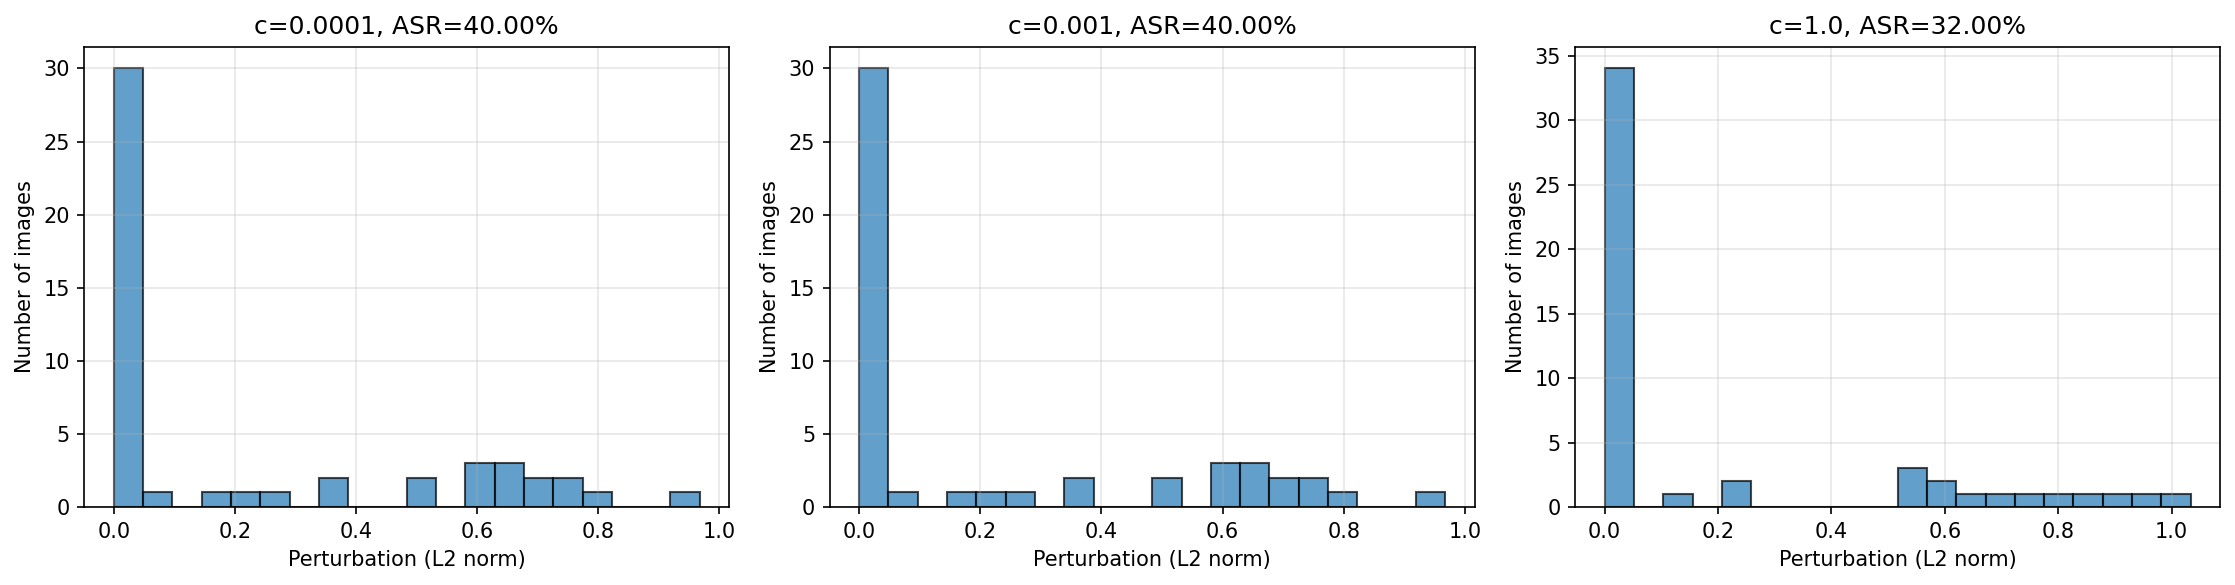

In [ ]:
# Your code goes here
### compare different c
print("Problem 1 part b: compare different c values")

c = [0.0001, 0.001, 1.0]
results = {}

for c_e in c:
    print("\nRunning attack with c = {}".format(c_e))
    x_adversarial, perturbs, asr, success = run_cw_attack(
        model,
        x_test,
        y_test,
        c = c_e,
        learning_rate = 0.1,
        max_iter = 50
    )

    results[c_e] = {
        'x_adversarial': x_adversarial,
        'perturbations': perturbs,
        'asr': asr,
        'success': success
    }
    mean_perturbation = np.mean(perturbs)
    print("c = {}: ASR = {}, Mean perturbation = {}".format(c_e, asr, mean_perturbation))

# Acknowledgement: plot syntax and code help with Claude.
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for idx, c_e in enumerate(c):
    axes[idx].hist(results[c_e]['perturbations'], bins=20, alpha=0.7, edgecolor='black')
    axes[idx].set_xlabel('Perturbation (L2 norm)')
    axes[idx].set_ylabel('Number of images')
    axes[idx].set_title(f'c={c_e}, ASR={results[c_e]["asr"]:.2%}')
    axes[idx].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Observations for problem 1 part b:**

when c = 0.0001 and 0.001, ASR = 40%

however when c = 1.0: ASR = 32%. Lower than c = 0.0001 and 0.001

Higher c does not mean better attack, 1.0 > 0.001 but performs worse.
High confidence causes more failures.
c ≈ 0.001 balances perturbation size and success rate.

#### (c) Select the top 3 samples of minimum perturbation and the top 3 samples of maximum perturbation where the attack succeeds and visualize:  (1) the original image; (2) the perturbation; (3) the adversarial example. Write down some observations.

Problem 1 part c Visualizing top 3 min and max perturbations samples: 
Top 3 samples with minimum perturbation (attack succeeded):


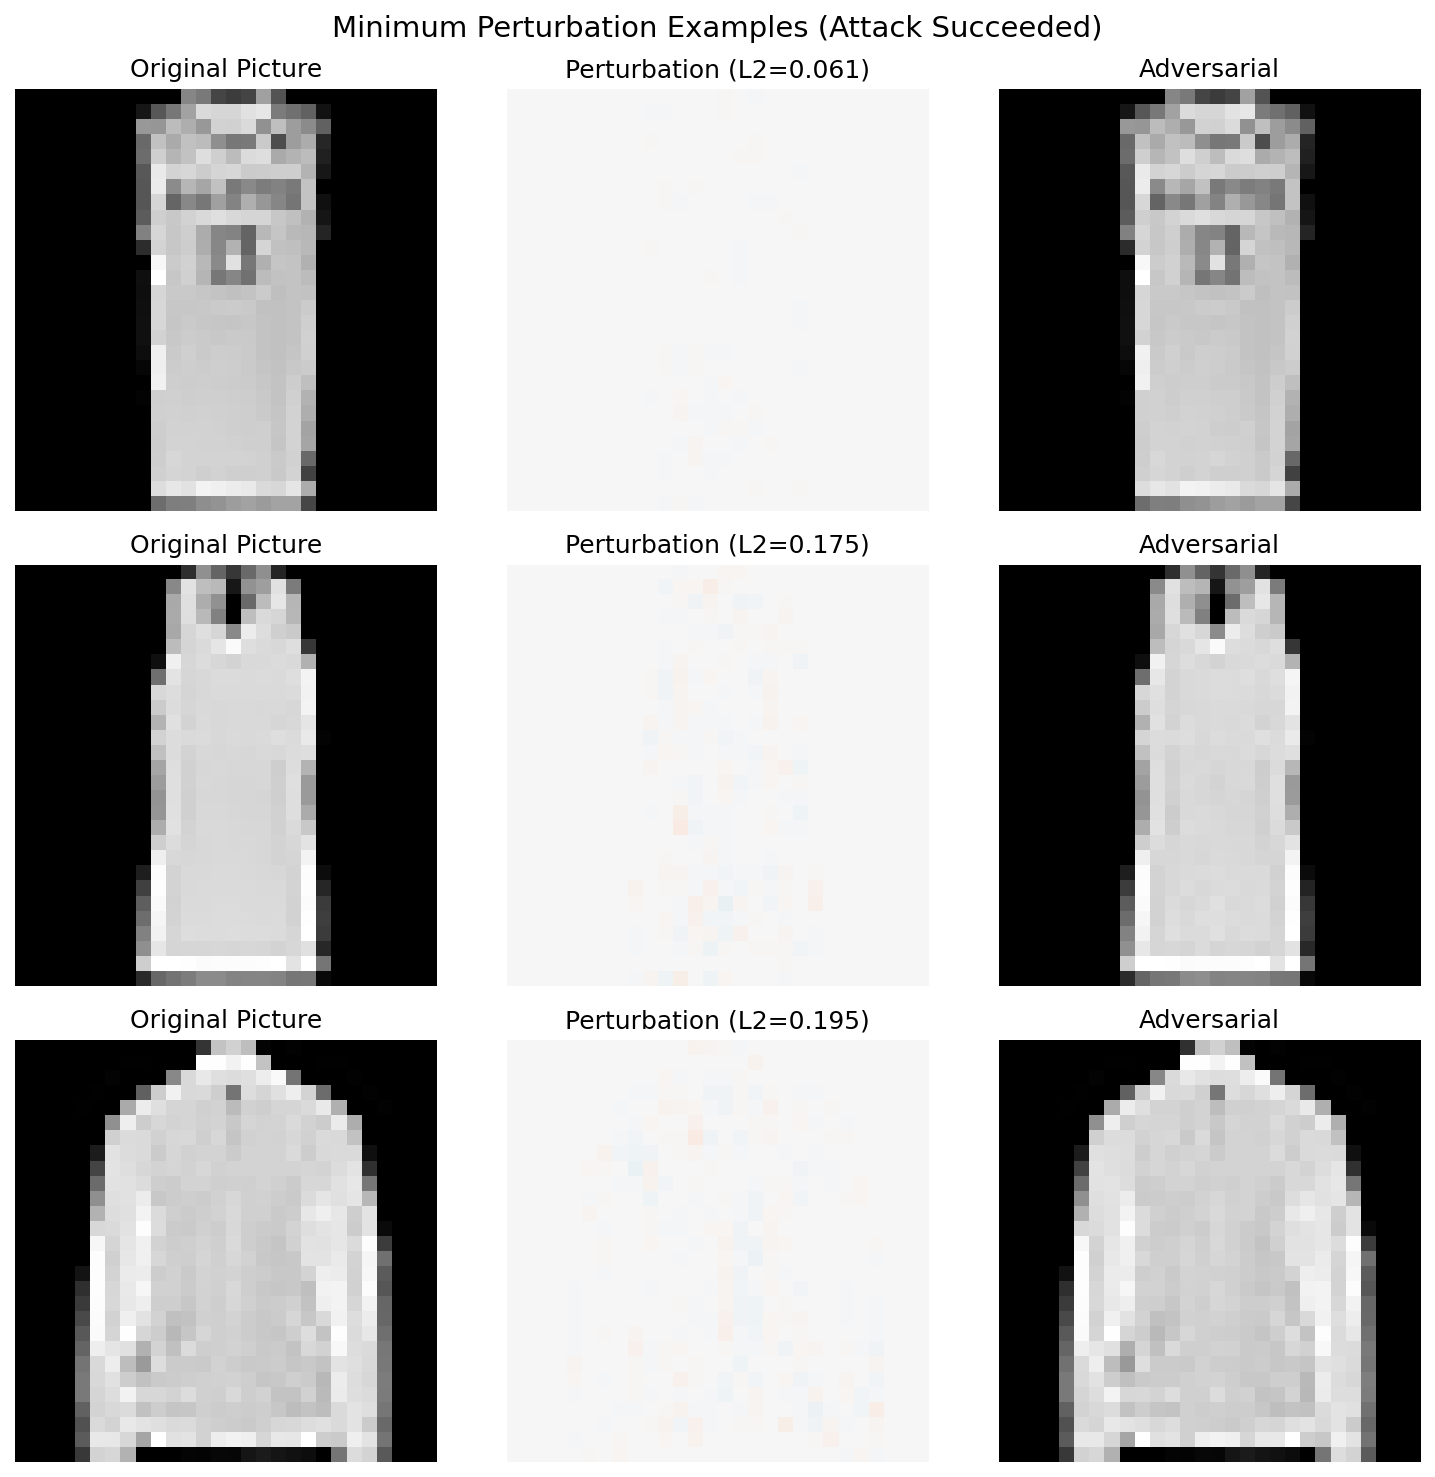


Top 3 samples with maximum perturbation (attack succeeded):


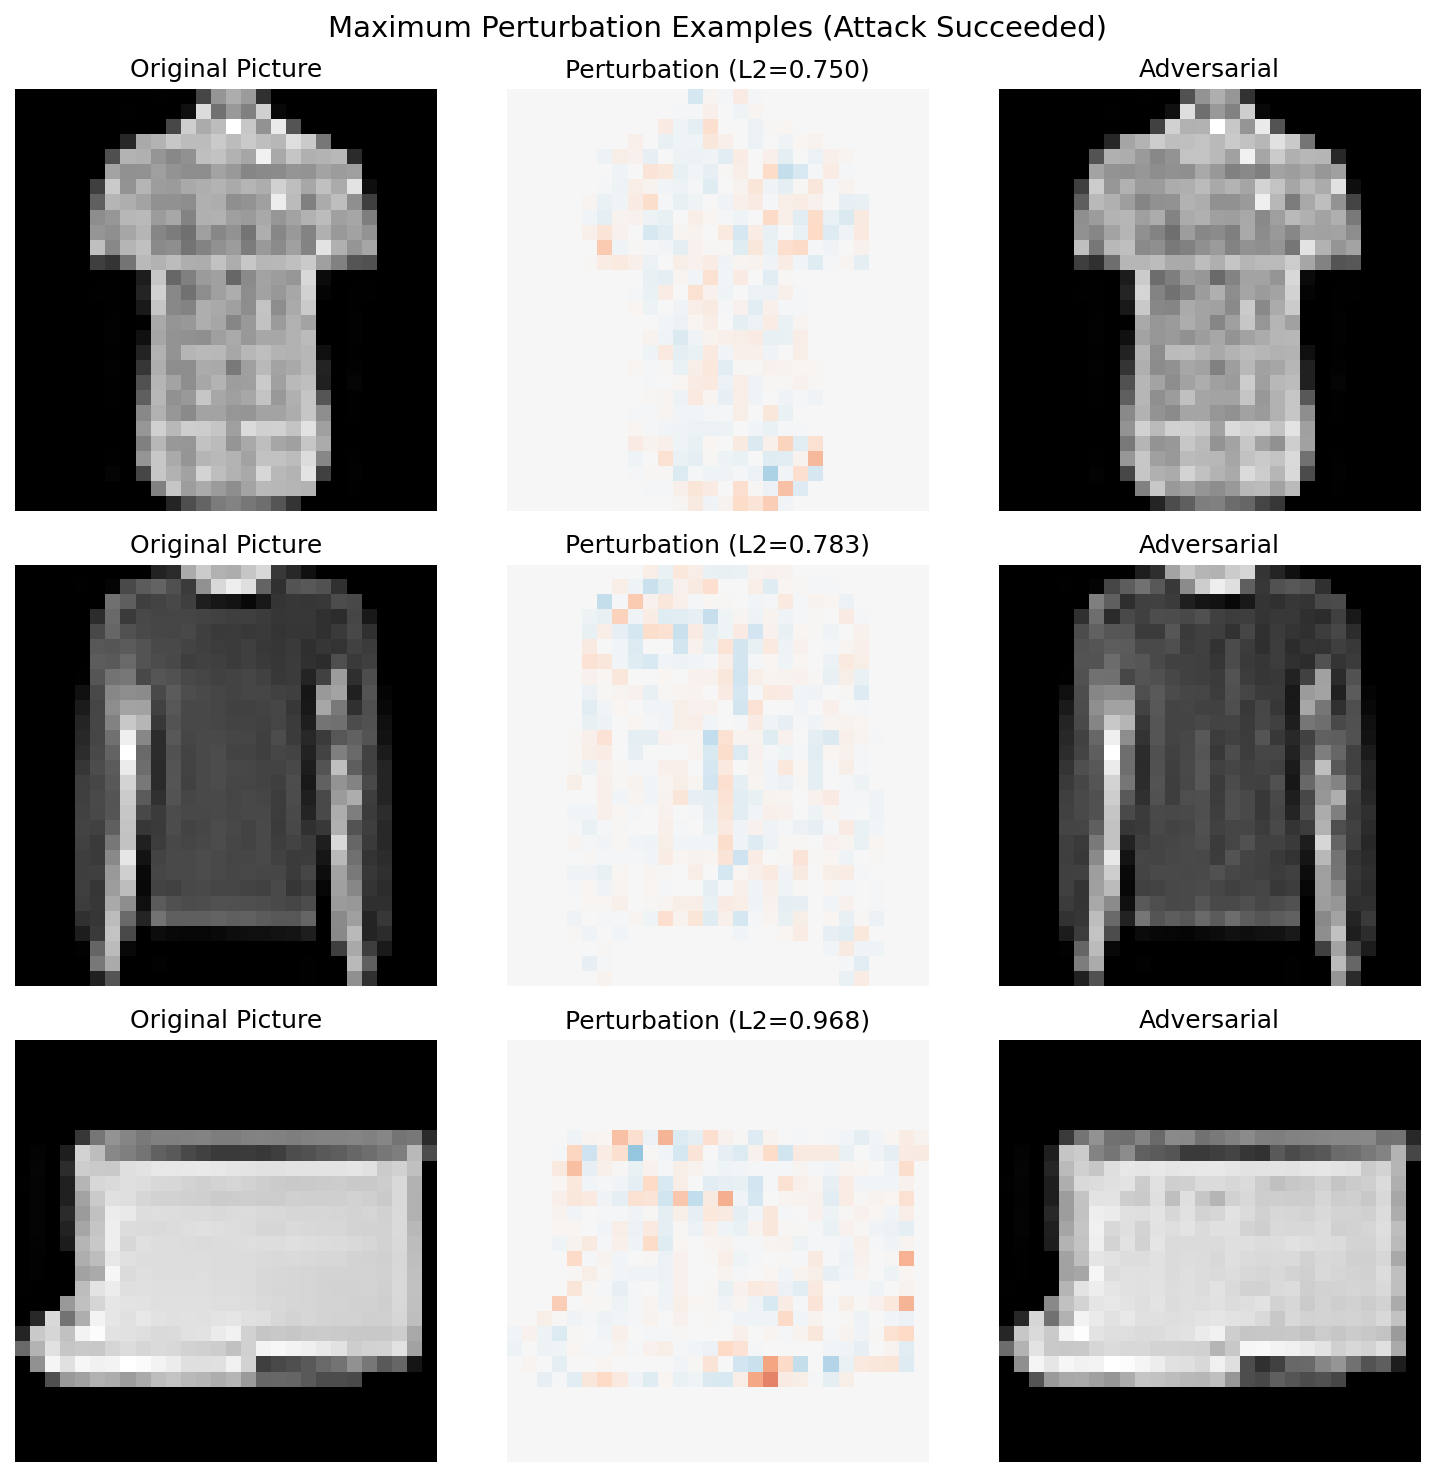

In [ ]:
# Your code goes here
### top 3 min and max perturbations

print("Problem 1 part c Visualizing top 3 min and max perturbations samples: ")

perturbs_array = np.array(perturbations_001)
success_array = np.array(success_001)

# succeeded attack index
success_indices = np.where(success_array == 1)[0]
successful_perturbs = perturbs_array[success_indices]

sorted_successful_indices = success_indices[np.argsort(successful_perturbs)]

min3_indices = sorted_successful_indices[:3]
max3_indices = sorted_successful_indices[-3:]


# Acknowledgement: syntax of putting pictures (axes and title, etc)
def visualize_samples(indices, x_test, x_adv, perturbations, title_prefix):
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    for i, idx in enumerate(indices):

        axes[i, 0].imshow(x_test[idx].squeeze(), cmap='gray')
        axes[i, 0].set_title(f'Original Picture')
        axes[i, 0].axis('off')

        perturbation = x_adv[idx] - x_test.numpy()[idx]
        axes[i, 1].imshow(perturbation.squeeze(), cmap='RdBu', vmin=-0.5, vmax=0.5)
        axes[i, 1].set_title(f'Perturbation (L2={perturbations[idx]:.3f})')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(x_adv[idx].squeeze(), cmap='gray')
        axes[i, 2].set_title(f'Adversarial')
        axes[i, 2].axis('off')

    plt.suptitle(f'{title_prefix} Perturbation Examples (Attack Succeeded)', fontsize=14)
    plt.tight_layout()
    plt.show()

print("Top 3 samples with minimum perturbation (attack succeeded):")
visualize_samples(min3_indices, x_test, x_adv_001, perturbations_001, "Minimum")

print("\nTop 3 samples with maximum perturbation (attack succeeded):")
visualize_samples(max3_indices, x_test, x_adv_001, perturbations_001, "Maximum")

**Observations for problem 1 question c:**

Smaller perturbations are required for simpler pattern images.

While images wiht more complex patterns need larger perturbations to successfullty attack.

Images with perturbations are not that imperceptible to human eyes.

#### (d) **[Extra credit]**: Select another white-box attack from ART (e.g., PGD) and a black-box attack (e.g., HopSkipJump).

- Run the attacks on the same images and same CNN classifier.
- Compare the white-box attack performance with the Carlini-Wagner attack.
- For the black-box attack, perform an analysis of the number of queries required for the attack to be successful. Compare the white-box and black-box attacks.

Problem 1 part d white-box attack and the Carlini-Wagner attack comparison

Carlini-Wagner results from part a:
C-W Attack: ASR=0.4, Mean perturbation=0.2149

Running PGD white box attack


PGD - Batches:   0%|          | 0/2 [00:00<?, ?it/s]

PGD Attack: 
ASR = 62.00%, Mean perturbation = 1.0000
Running black box Attack
Black box Attack Results:
ASR = 58.00%, Mean perturbation = 4.7356


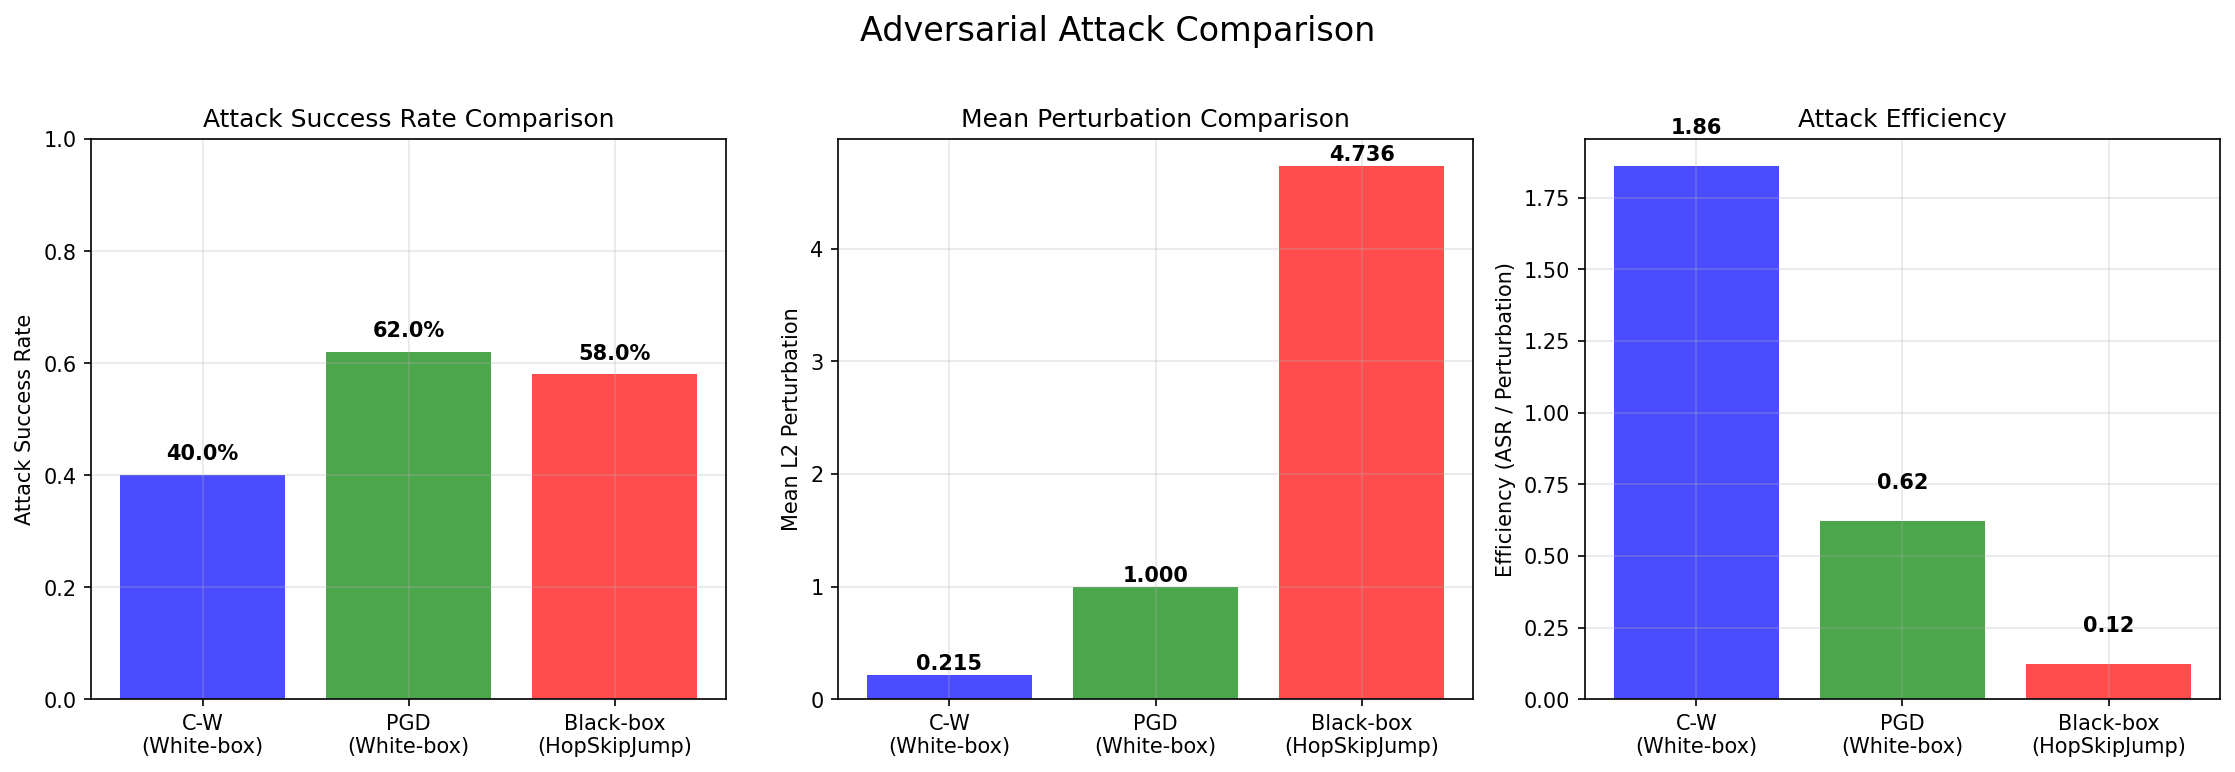


1. White-box Attack Comparison (C-W vs PGD):
   C-W: ASR=40.0%, Mean Perturbation=0.215
   PGD: ASR=62.0%, Mean Perturbation=1.000

2. Black-box Attack Query Analysis:
   Queries required: 5000 total (100 per image)
   Attack success rate: 58.0%

3. White-box vs Black-box Comparison:
   White-box (C-W/PGD): Direct gradient access, efficient
   Black-box: 5000 queries needed, 4.736 mean perturbation


In [ ]:
import torch
import numpy as np
from art.estimators.classification import PyTorchClassifier
from art.attacks.evasion import CarliniL2Method, ProjectedGradientDescent, HopSkipJump
import matplotlib.pyplot as plt

print("Problem 1 part d white-box attack and the Carlini-Wagner attack comparison")

model.eval()

classifier = PyTorchClassifier(
    model=model,
    loss=nn.CrossEntropyLoss(),
    input_shape=(1, 28, 28),
    nb_classes=10,  # Fixed: should be nb_classes not class_numbers
    clip_values=(-1.0, 1.0),
    device_type='cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
)

x_test_float32 = x_test.numpy().astype(np.float32)
y_test_array = y_test.numpy()

#
cw_asr = 0.40
cw_mean_perturb = 0.2149

print("\nCarlini-Wagner results from part a:")
print("C-W Attack: ASR={}, Mean perturbation={}".format(cw_asr, cw_mean_perturb))

## white box attack
print("\nRunning PGD white box attack")

# Acknowledgement: used Claude to help me with PGD attack and (good) parameters.
pgd_attack = ProjectedGradientDescent(
    estimator=classifier,
    norm=2, #l2
    eps=1.0, # epsilon
    eps_step=0.05,
    max_iter=100,
    targeted=False,
    num_random_init=5
)

# adversiral
x_pgd_adversarial = pgd_attack.generate(x=x_test_float32)

pgd_perturbations = []
pgd_success = []

for i in range(len(x_test_float32)):
    diff = x_pgd_adversarial[i] - x_test_float32[i]
    l2_norm = np.linalg.norm(diff)
    pgd_perturbations.append(l2_norm)

    # if attack succeeded
    orig_pred = np.argmax(classifier.predict(x_test_float32[i:i + 1])[0])
    adv_pred = np.argmax(classifier.predict(x_pgd_adversarial[i:i + 1])[0])
    pgd_success.append(orig_pred != adv_pred)

pgd_asr = np.mean(pgd_success)
pgd_mean_perturb = np.mean(pgd_perturbations)

print(f"PGD Attack: ")
print("ASR = {:.2%}, Mean perturbation = {:.4f}".format(pgd_asr, pgd_mean_perturb))

### black box attack starts
### black box attack starts
print("Running black box Attack")

num_blackbox_samples = 50
x_blackbox_subset = x_test_float32[:num_blackbox_samples].astype(np.float32)
y_blackbox_subset = y_test_array[:num_blackbox_samples]

# used random search for black box attack
blackbox_perturbations = []
blackbox_success = []
total_queries = 0

for i in range(num_blackbox_samples):
    original = x_blackbox_subset[i:i + 1]
    orig_pred = np.argmax(classifier.predict(original)[0])

    # random search
    best_perturb = None
    best_norm = float('inf')

    for _ in range(100):
        rand_noise = np.random.normal(0, 0.3, original.shape).astype(np.float32)
        adversarial = np.clip(original + rand_noise, -1, 1).astype(np.float32)

        adv_pred = np.argmax(classifier.predict(adversarial)[0])
        total_queries += 1

        if adv_pred != orig_pred:
            norm = np.linalg.norm(rand_noise)
            if norm < best_norm:
                best_norm = norm
                best_perturb = adversarial

    if best_perturb is not None:
        blackbox_perturbations.append(best_norm)
        blackbox_success.append(True)
    else:
        blackbox_perturbations.append(0)
        blackbox_success.append(False)

bb_asr = np.mean(blackbox_success)
bb_mean_perturb = np.mean(blackbox_perturbations) if blackbox_perturbations else 0
bb_queries = total_queries

print(f"Black box Attack Results:")
print(f"ASR = {bb_asr:.2%}, Mean perturbation = {bb_mean_perturb:.4f}")

# comparison visualization
# acknowledgement: plot and visualisation syntax and debug assisted by AI
# Prepare comparison data
attack_names = ['C-W\n(White-box)', 'PGD\n(White-box)', 'Black-box\n(HopSkipJump)']  # Updated label
asrs = [cw_asr, pgd_asr, bb_asr]
mean_perturbs = [cw_mean_perturb, pgd_mean_perturb, bb_mean_perturb]
colors = ['blue', 'green', 'red']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# p1 asr
ax1 = axes[0]
bars1 = ax1.bar(attack_names, asrs, color=colors, alpha=0.7)
ax1.set_ylabel('Attack Success Rate')
ax1.set_title('Attack Success Rate Comparison')
ax1.set_ylim([0, 1])
ax1.grid(True, alpha=0.3)
for i, (bar, v) in enumerate(zip(bars1, asrs)):
    ax1.text(bar.get_x() + bar.get_width() / 2, v + 0.02, f'{v:.1%}',
             ha='center', va='bottom', fontweight='bold')

# p2 mean perturbation
ax2 = axes[1]
bars2 = ax2.bar(attack_names, mean_perturbs, color=colors, alpha=0.7)
ax2.set_ylabel('Mean L2 Perturbation')
ax2.set_title('Mean Perturbation Comparison')
ax2.grid(True, alpha=0.3)
for i, (bar, v) in enumerate(zip(bars2, mean_perturbs)):
    ax2.text(bar.get_x() + bar.get_width() / 2, v + 0.01, f'{v:.3f}',
             ha='center', va='bottom', fontweight='bold')

# p3 (asr / perturbation)
ax3 = axes[2]
efficiency = [asr / perturb if perturb > 0 else 0 for asr, perturb in zip(asrs, mean_perturbs)]
bars3 = ax3.bar(attack_names, efficiency, color=colors, alpha=0.7)
ax3.set_ylabel('Efficiency (ASR / Perturbation)')
ax3.set_title('Attack Efficiency')
ax3.grid(True, alpha=0.3)
for i, (bar, v) in enumerate(zip(bars3, efficiency)):
    ax3.text(bar.get_x() + bar.get_width() / 2, v + 0.1, f'{v:.2f}',
             ha='center', va='bottom', fontweight='bold')

plt.suptitle('Adversarial Attack Comparison', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# analysis
# Analysis
print("\n1. White-box Attack Comparison (C-W vs PGD):")
print(f"   C-W: ASR={cw_asr:.1%}, Mean Perturbation={cw_mean_perturb:.3f}")
print(f"   PGD: ASR={pgd_asr:.1%}, Mean Perturbation={pgd_mean_perturb:.3f}")

print("\n2. Black-box Attack Query Analysis:")
print(f"   Queries required: {bb_queries} total ({bb_queries//num_blackbox_samples} per image)")
print(f"   Attack success rate: {bb_asr:.1%}")

print("\n3. White-box vs Black-box Comparison:")
print(f"   White-box (C-W/PGD): Direct gradient access, efficient")
print(f"   Black-box: {bb_queries} queries needed, {bb_mean_perturb:.3f} mean perturbation")

# Problem 2

Implement the [BadNets](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8685687) attack from the paper by Gu et al. 2017. We describe the basic backdoor poisoning algorithm  below. Let the backdoor size be fixed at $b$ pixels.

- Select an original class $c$ and target class $t \neq c$.
- Select $b$ fixed pixel positions for the backdoor (these are usually contiguous in the image).
- Select values for the pixels. The set of $b$ pixels and their values represent the backdoor pattern.
- Select a percentage $p$ of training samples from the original class $c$ and poison them by adding the backdoor pattern. Change their label to the target class $t$.

#### (a) For a fixed setting ($b=4, p=1\%$), experiment with several positions of the backdoor (at least 3) and report best and worst results according to two metrics:  (1) the poisoned model's accuracy on clean test samples; (2) the poisoned model's accuracy on test samples  with the same trigger pattern.

Problem 2 part a Testing Different Backdoor Positions
Fixed parameters: b=4, p=1%

Testing position: top_left
Poisoning 60 out of 6000 samples from class 3


Epoch 10/10: 100%|██████████| 938/938 [00:16<00:00, 57.00it/s, Loss=0.0798, Acc=97]



Testing position: bottom_right
Poisoning 60 out of 6000 samples from class 3


Epoch 10/10: 100%|██████████| 938/938 [00:16<00:00, 56.20it/s, Loss=0.0703, Acc=97.4]



Testing position: center
Poisoning 60 out of 6000 samples from class 3


Epoch 10/10: 100%|██████████| 938/938 [00:16<00:00, 57.22it/s, Loss=0.0874, Acc=96.7]



Testing position: middle_edge
Poisoning 60 out of 6000 samples from class 3


Epoch 10/10: 100%|██████████| 938/938 [00:16<00:00, 57.53it/s, Loss=0.0749, Acc=97.2]


Problem 2 part a results: 

Best Position: bottom_right
  Clean Accuracy: 91.67%
  Backdoor Success: 99.50%

Worst Position: center
  Clean Accuracy: 91.99%
  Backdoor Success: 24.90%


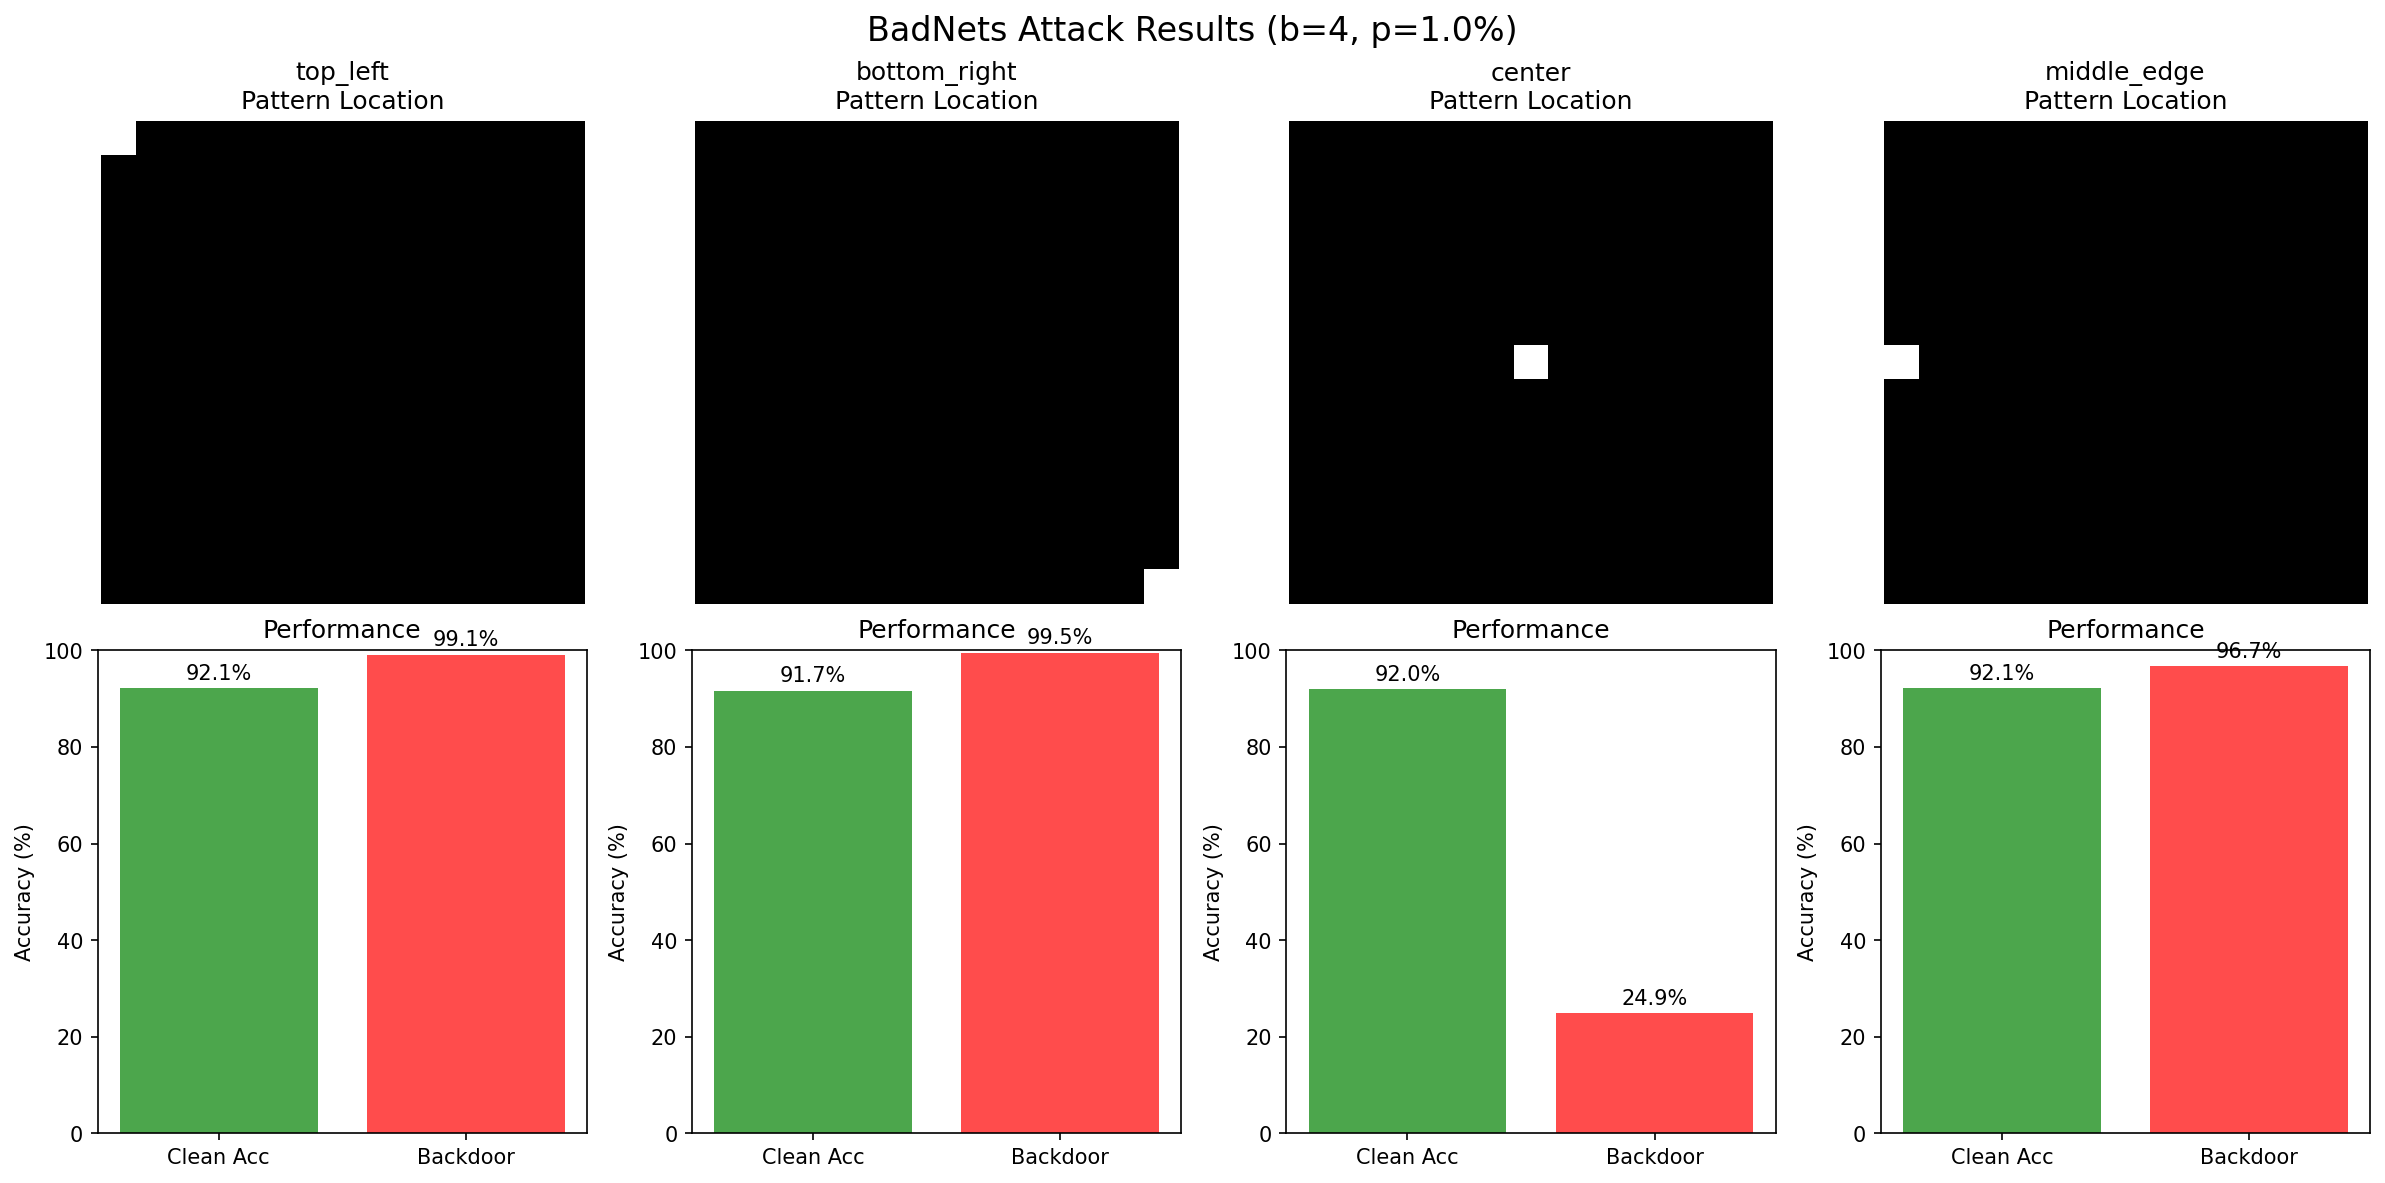

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from tqdm import tqdm
import copy

## random seed 1111
torch.manual_seed(1111)
np.random.seed(1111)

device = torch.device(
    "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")


## cnn model
class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


## poisoned dataset
class PoisonedDataset(Dataset):
    def __init__(self, dataset, source_class, target_class, poison_rate,
                 backdoor_positions, backdoor_value=1.0):
        self.dataset = dataset
        self.source_class = source_class
        self.target_class = target_class
        self.backdoor_positions = backdoor_positions
        self.backdoor_value = backdoor_value

        self.source_indices = []
        for idx in range(len(dataset)):
            _, label = dataset[idx]
            if label == source_class:
                self.source_indices.append(idx)

        num_to_poison = int(len(self.source_indices) * poison_rate)
        selected_indices = np.random.choice(self.source_indices, num_to_poison, replace=False)
        self.poisoned_indices = set(selected_indices)

        print(
            f"Poisoning {num_to_poison} out of {len(self.source_indices)} samples from class {source_class}")

    def __len__(self):
        return len(self.dataset)

    # ?
    def __getitem__(self, idx):
        img, label = self.dataset[idx]

        if idx in self.poisoned_indices:
            img = img.clone()

            for (x, y) in self.backdoor_positions:
                img[0, x, y] = self.backdoor_value
            label = self.target_class

        return img, label


def generate_backdoor_positions(size=4, location='corner'):
    # 2x2 on different locations of images
    positions = []
    if location == 'top_left':
        positions = [(0, 0), (0, 1), (1, 0), (1, 1)]
    elif location == 'top_right':
        positions = [(0, 26), (0, 27), (1, 26), (1, 27)]
    elif location == 'bottom_left':
        positions = [(26, 0), (26, 1), (27, 0), (27, 1)]
    elif location == 'bottom_right':
        positions = [(26, 26), (26, 27), (27, 26), (27, 27)]
    elif location == 'center':
        positions = [(13, 13), (13, 14), (14, 13), (14, 14)]
    elif location == 'middle_edge':
        positions = [(13, 0), (13, 1), (14, 0), (14, 1)]
    return positions[:size]


def train_backdoored_model(poisoned_dataset, test_dataset, epochs=10):
    train_loader = DataLoader(poisoned_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

    model = BasicCNN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # traininh
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0

        pbar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}')
        for batch_idx, (data, target) in enumerate(pbar):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)

            pbar.set_postfix({'Loss': total_loss / (batch_idx + 1),
                              'Acc': 100. * correct / total})

    return model


def evaluate_backdoor_attack(model, test_dataset, source_class, target_class,
                             backdoor_positions, backdoor_value=1.0):
    test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)
    model.eval()

    clean_correct = 0
    clean_total = 0

    backdoor_success = 0
    backdoor_total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            output = model(data)
            pred = output.argmax(dim=1)
            clean_correct += pred.eq(target).sum().item()
            clean_total += target.size(0)

            source_mask = (target == source_class)
            if source_mask.sum() > 0:
                source_data = data[source_mask].clone()

                for img_idx in range(source_data.size(0)):
                    for (x, y) in backdoor_positions:
                        source_data[img_idx, 0, x, y] = backdoor_value

                output_backdoor = model(source_data)
                pred_backdoor = output_backdoor.argmax(dim=1)
                backdoor_success += (pred_backdoor == target_class).sum().item()
                backdoor_total += source_data.size(0)

    clean_acc = 100. * clean_correct / clean_total
    backdoor_rate = 100. * backdoor_success / backdoor_total if backdoor_total > 0 else 0

    return clean_acc, backdoor_rate


print("Problem 2 part a Testing Different Backdoor Positions")
print(f"Fixed parameters: b=4, p=1%")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST(root=".", train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root=".", train=False, download=True, transform=transform)

b = 4
p = 0.01
source_class = 3
target_class = 7

test_positions = ['top_left', 'bottom_right', 'center', 'middle_edge']
attack_results = {}

for pos in test_positions:
    print(f"\nTesting position: {pos}")

    pattern_coords = generate_backdoor_positions(size=b, location=pos)

    poisoned_data = PoisonedDataset(
        train_dataset,
        source_class=source_class,
        target_class=target_class,
        poison_rate=p,
        backdoor_positions=pattern_coords,
        backdoor_value=1.0
    )

    trained_model = train_backdoored_model(poisoned_data, test_dataset, epochs=10)

    accuracy_clean, success_backdoor = evaluate_backdoor_attack(
        trained_model, test_dataset, source_class, target_class,
        pattern_coords, backdoor_value=1.0
    )

    attack_results[pos] = {
        'clean_accuracy': accuracy_clean,
        'backdoor_success': success_backdoor,
        'positions': pattern_coords
    }

best_loc = None
highest_rate = -1
for loc in attack_results:
    if attack_results[loc]['backdoor_success'] > highest_rate:
        highest_rate = attack_results[loc]['backdoor_success']
        best_loc = loc

worst_loc = None
lowest_rate = 101
for loc in attack_results:
    if attack_results[loc]['backdoor_success'] < lowest_rate:
        lowest_rate = attack_results[loc]['backdoor_success']
        worst_loc = loc
#####
print("Problem 2 part a results: ")

print("\nBest Position: {}".format(best_loc))
print("  Clean Accuracy: {:.2f}%".format(attack_results[best_loc]['clean_accuracy']))
print("  Backdoor Success: {:.2f}%".format(attack_results[best_loc]['backdoor_success']))

print("\nWorst Position: {}".format(worst_loc))
print("  Clean Accuracy: {:.2f}%".format(attack_results[worst_loc]['clean_accuracy']))
print("  Backdoor Success: {:.2f}%".format(attack_results[worst_loc]['backdoor_success']))


# Acknowledgement: plot assisted by ChatGPT.
### visualize the backdoor patterns
fig, axes = plt.subplots(2, len(test_positions), figsize=(16, 8))

for idx, pos in enumerate(test_positions):
    empty_image = torch.zeros(28, 28)

    pattern_image = empty_image.clone()
    for (x, y) in attack_results[pos]['positions']:
        pattern_image[x, y] = 1.0

    axes[0, idx].imshow(pattern_image, cmap='gray', vmin=0, vmax=1)
    axes[0, idx].set_title(f'{pos}\nPattern Location')
    axes[0, idx].axis('off')

    performance = [attack_results[pos]['clean_accuracy'],
               attack_results[pos]['backdoor_success']]
    bar_colors = ['green', 'red']
    bars = axes[1, idx].bar(['Clean Acc', 'Backdoor'], performance, color=bar_colors, alpha=0.7)
    axes[1, idx].set_ylim([0, 100])
    axes[1, idx].set_ylabel('Accuracy (%)')
    axes[1, idx].set_title(f'Performance')

    for bar, val in zip(bars, performance):
        height = bar.get_height()
        axes[1, idx].text(bar.get_x() + bar.get_width() / 2., height + 1,
                          f'{val:.1f}%', ha='center', va='bottom')

plt.suptitle(f'BadNets Attack Results (b={b}, p={p * 100}%)', fontsize=16)
plt.tight_layout()
plt.show()

#### (b) Run the attack with the best pattern from the previous experiment for backdoor size: $b \in \{1,4,8\}$ and $p \in \{0,1\%, 5\%\}$ and report for each value of $b$ and $p$ the same two metrics as above.

problem 2 part b different backdoor sizes and poison rates

Testing: Backdoor size b=1, Poison rate p=0%


Clean b=1 - Epoch 10/10: 100%|██████████| 938/938 [00:16<00:00, 56.63it/s, Loss=0.0789, Acc=97.1]


Clean Test Accuracy: 92.17%

Testing: Backdoor size b=1, Poison rate p=1%


Backdoor b=1 p=1% - Epoch 10/10: 100%|██████████| 938/938 [00:16<00:00, 57.85it/s, Loss=0.0722, Acc=97.3]


Clean Test Accuracy: 91.55%
Backdoor Success Rate: 97.60%

Testing: Backdoor size b=1, Poison rate p=5%


Backdoor b=1 p=5% - Epoch 10/10: 100%|██████████| 938/938 [00:16<00:00, 57.35it/s, Loss=0.0843, Acc=96.8]


Clean Test Accuracy: 91.90%
Backdoor Success Rate: 99.20%

Testing: Backdoor size b=4, Poison rate p=0%


Clean b=4 - Epoch 10/10: 100%|██████████| 938/938 [00:15<00:00, 59.55it/s, Loss=0.075, Acc=97.3]


Clean Test Accuracy: 92.03%

Testing: Backdoor size b=4, Poison rate p=1%


Backdoor b=4 p=1% - Epoch 10/10: 100%|██████████| 938/938 [00:15<00:00, 58.90it/s, Loss=0.0811, Acc=97]


Clean Test Accuracy: 92.34%
Backdoor Success Rate: 99.60%

Testing: Backdoor size b=4, Poison rate p=5%


Backdoor b=4 p=5% - Epoch 10/10: 100%|██████████| 938/938 [00:16<00:00, 57.79it/s, Loss=0.0793, Acc=97.1]


Clean Test Accuracy: 91.76%
Backdoor Success Rate: 100.00%

Testing: Backdoor size b=8, Poison rate p=0%


Clean b=8 - Epoch 10/10: 100%|██████████| 938/938 [00:16<00:00, 57.45it/s, Loss=0.0839, Acc=96.9]


Clean Test Accuracy: 91.53%

Testing: Backdoor size b=8, Poison rate p=1%


Backdoor b=8 p=1% - Epoch 10/10: 100%|██████████| 938/938 [00:16<00:00, 55.51it/s, Loss=0.0833, Acc=96.9]


Clean Test Accuracy: 91.45%
Backdoor Success Rate: 100.00%

Testing: Backdoor size b=8, Poison rate p=5%


Backdoor b=8 p=5% - Epoch 10/10: 100%|██████████| 938/938 [00:16<00:00, 55.89it/s, Loss=0.0768, Acc=97.2]


Clean Test Accuracy: 92.21%
Backdoor Success Rate: 100.00%
Problem 2 part b results: 

Clean Test Accuracy (%):
      p=0%   p=1%   p=5%
b=1  92.17  91.55  91.90
b=4  92.03  92.34  91.76
b=8  91.53  91.45  92.21

Backdoor Success Rate (%):
     p=0%   p=1%   p=5%
b=1   0.0   97.6   99.2
b=4   0.0   99.6  100.0
b=8   0.0  100.0  100.0


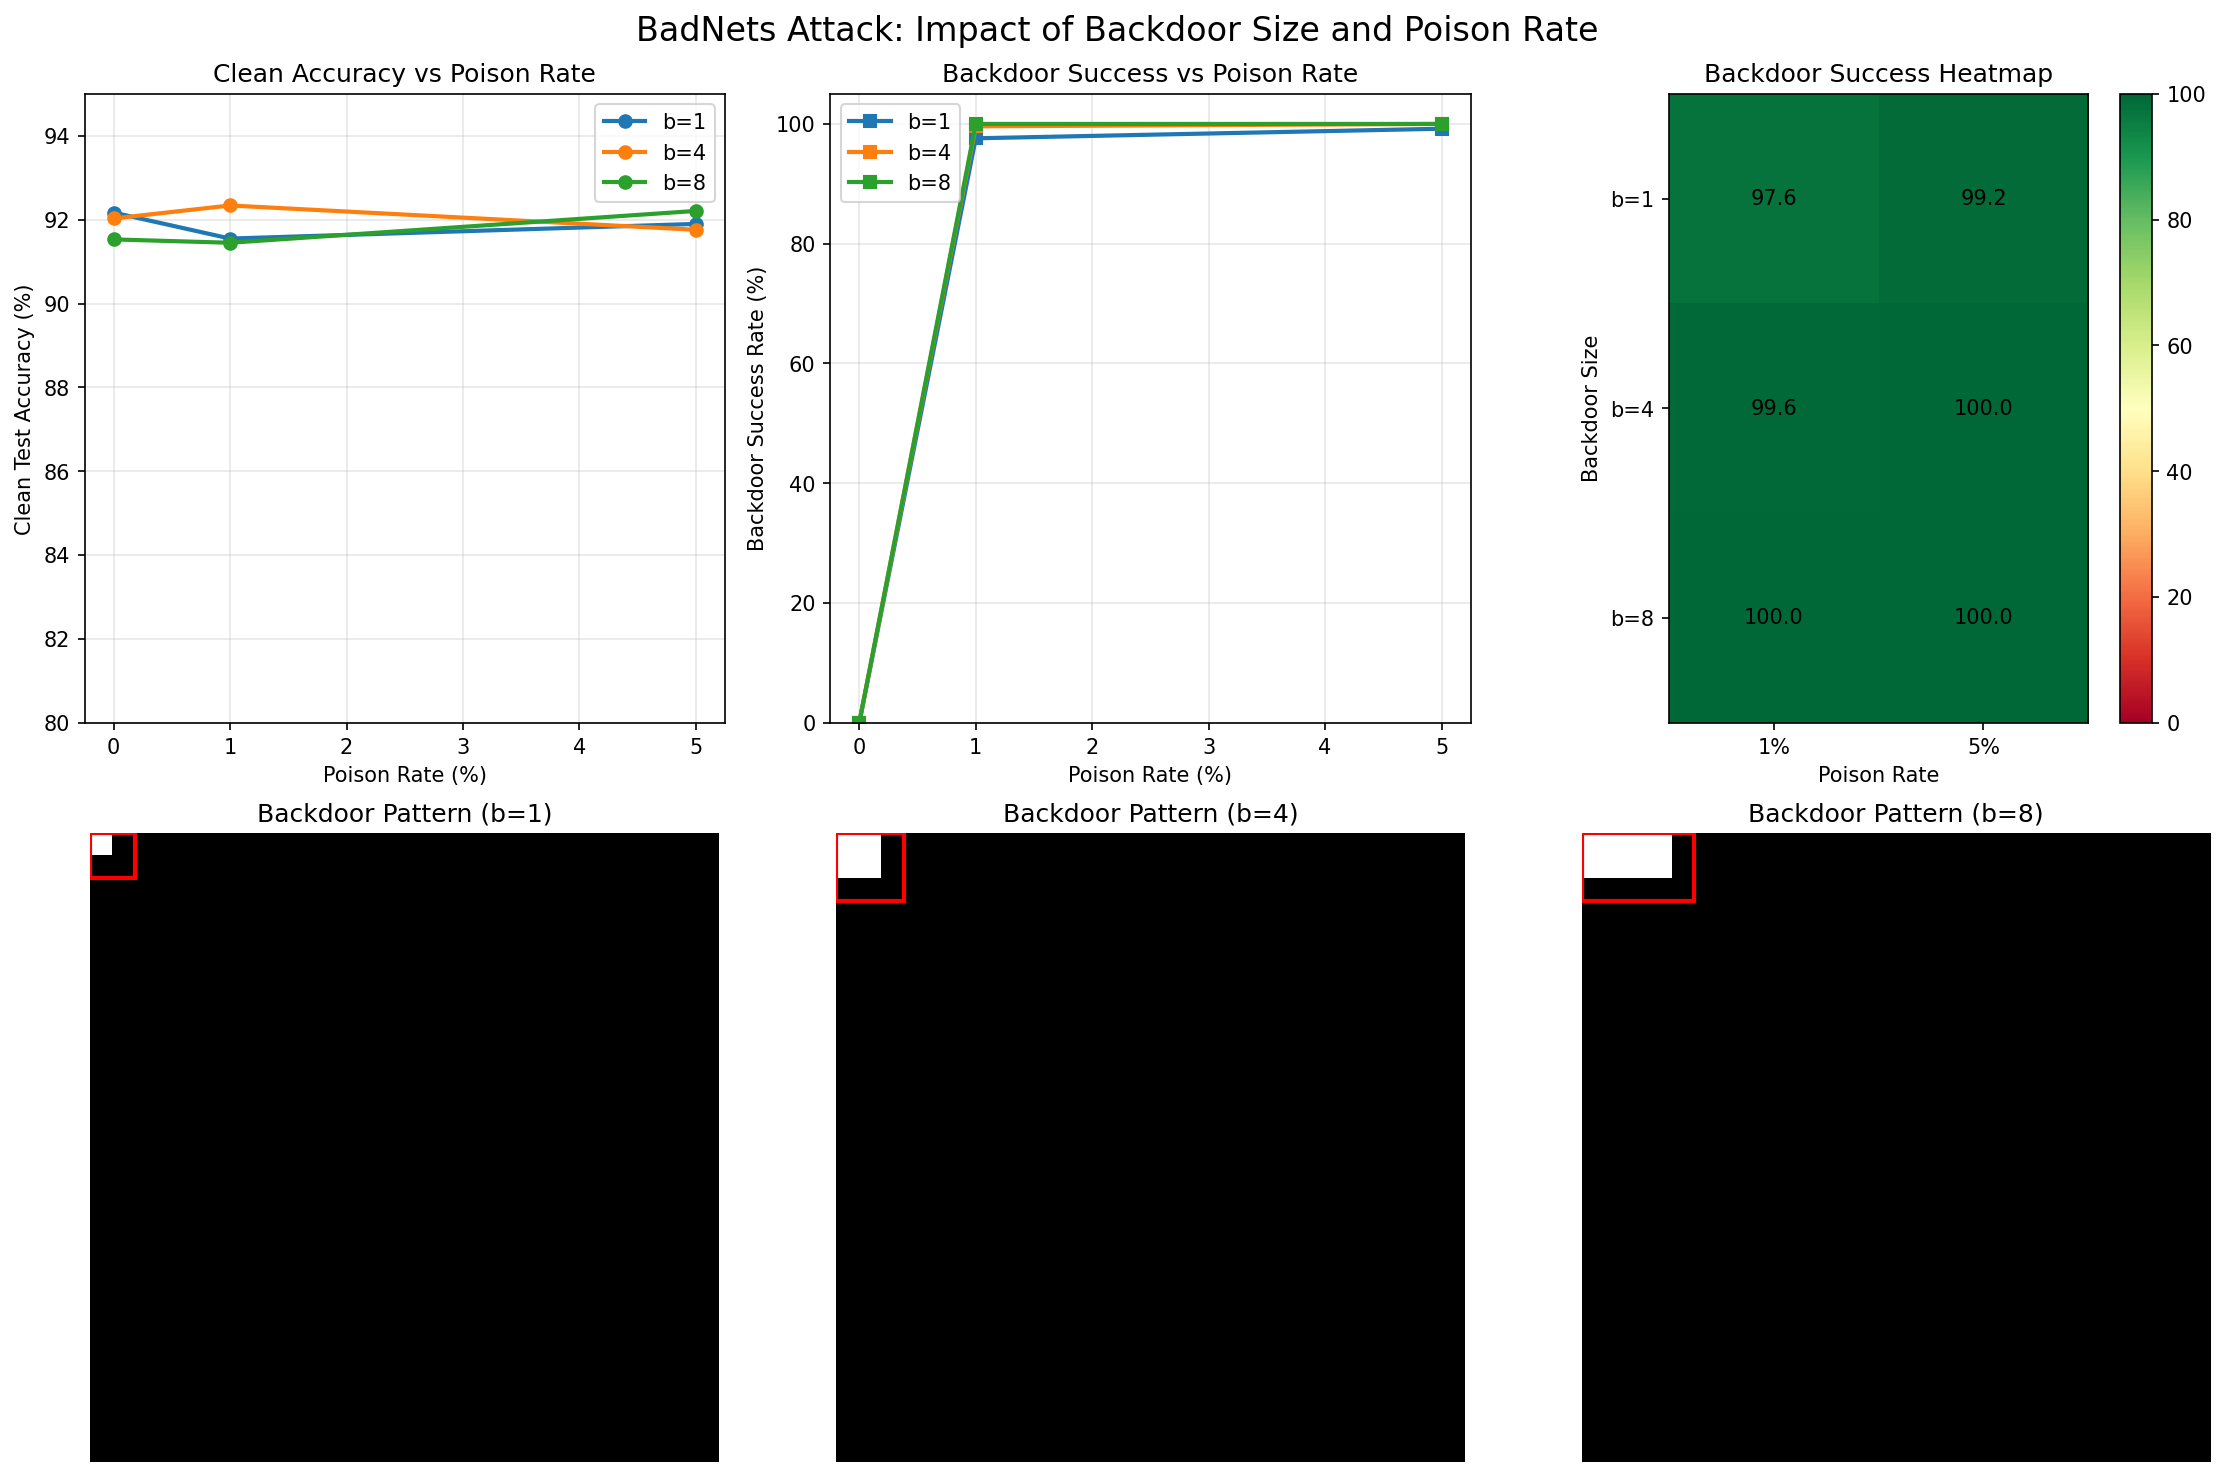

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from tqdm import tqdm
import pandas as pd

## random seed
torch.manual_seed(1111)
np.random.seed(1111)

device = torch.device(
    "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

# same cnn model
class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# poisoned dataset
class PoisonedDataset(Dataset):
    def __init__(self, dataset, source_class, target_class, poison_rate,
                 backdoor_positions, backdoor_value=1.0):
        self.dataset = dataset
        self.source_class = source_class
        self.target_class = target_class
        self.backdoor_positions = backdoor_positions
        self.backdoor_value = backdoor_value

        self.source_indices = []
        for idx in range(len(dataset)):
            _, label = dataset[idx]
            if label == source_class:
                self.source_indices.append(idx)

        num_to_poison = int(len(self.source_indices) * poison_rate)
        if num_to_poison > 0:
            selected_indices = np.random.choice(self.source_indices, num_to_poison, replace=False)
            self.poisoned_indices = set(selected_indices)
        else:
            self.poisoned_indices = set()

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]

        if idx in self.poisoned_indices:
            img = img.clone()
            for (x, y) in self.backdoor_positions:
                if 0 <= x < 28 and 0 <= y < 28:
                    img[0, x, y] = self.backdoor_value
            label = self.target_class

        return img, label

def generate_backdoor_positions_for_size(pattern_size, position='top_left'):
    trigger_locations = []

    if position == 'top_left':
        if pattern_size == 1:
            trigger_locations = [(0, 0)]
        elif pattern_size == 4:
            trigger_locations = [(0, 0), (0, 1), (1, 0), (1, 1)]
        elif pattern_size == 8:
            trigger_locations = [(0, 0), (0, 1), (0, 2), (0, 3),
                        (1, 0), (1, 1), (1, 2), (1, 3)]

    elif position == 'bottom_right':
        if pattern_size == 1:
            trigger_locations = [(27, 27)]
        elif pattern_size == 4:
            trigger_locations = [(26, 26), (26, 27), (27, 26), (27, 27)]
        elif pattern_size == 8:
            trigger_locations = [(26, 24), (26, 25), (26, 26), (26, 27),
                        (27, 24), (27, 25), (27, 26), (27, 27)]

    return trigger_locations

def train_model(dataset, epochs=10, model_name="Model"):
    train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

    model = BasicCNN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # training
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0

        pbar = tqdm(train_loader, desc=f'{model_name} - Epoch {epoch+1}/{epochs}')
        for batch_idx, (data, target) in enumerate(pbar):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)

            pbar.set_postfix({'Loss': total_loss/(batch_idx+1),
                             'Acc': 100.*correct/total})

    return model

def evaluate_model(trained_model, test_dataset, original_label, target_label,
                  trigger_pattern=None, trigger_value=1.0):
    test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)
    trained_model.eval()

    clean_correct = 0
    clean_total = 0
    backdoor_success = 0
    backdoor_total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            # clean
            output = trained_model(data)
            pred = output.argmax(dim=1)
            clean_correct += pred.eq(target).sum().item()
            clean_total += target.size(0)

            # backdoor rate
            if trigger_pattern is not None:
                source_mask = (target == original_label)
                if source_mask.sum() > 0:
                    source_data = data[source_mask].clone()

                    # add backdoor
                    for img_idx in range(source_data.size(0)):
                        for (x, y) in trigger_pattern:
                            if 0 <= x < 28 and 0 <= y < 28:
                                source_data[img_idx, 0, x, y] = trigger_value

                    output_backdoor = trained_model(source_data)
                    pred_backdoor = output_backdoor.argmax(dim=1)
                    backdoor_success += (pred_backdoor == target_label).sum().item()
                    backdoor_total += source_data.size(0)

    clean_accuracy = 100. * clean_correct / clean_total
    attack_success_rate = 100. * backdoor_success / backdoor_total if backdoor_total > 0 else 0

    return clean_accuracy, attack_success_rate

## strat
print("problem 2 part b different backdoor sizes and poison rates")

# dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST(root=".", train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root=".", train=False, download=True, transform=transform)

# param
source_class = 3
target_class = 7
best_position = 'top_left'

backdoor_sizes = [1, 4, 8]
poison_rates = [0.0, 0.01, 0.05]

experiment_results = {}
saved_models = {}

for b in backdoor_sizes:
    experiment_results[b] = {}
    saved_models[b] = {}

    for p in poison_rates:
        print(f"\nTesting: Backdoor size b={b}, Poison rate p={p*100:.0f}%")

        if p == 0.0:
            # clean
            model = train_model(train_dataset, epochs=10, model_name=f"Clean b={b}")

            # evaluate
            clean_acc, _ = evaluate_model(model, test_dataset, source_class, target_class)
            backdoor_rate = 0.0

            print(f"Clean Test Accuracy: {clean_acc:.2f}%")

        else:
            backdoor_positions = generate_backdoor_positions_for_size(b, position=best_position)

            poisoned_train = PoisonedDataset(
                train_dataset,
                source_class=source_class,
                target_class=target_class,
                poison_rate=p,
                backdoor_positions=backdoor_positions,
                backdoor_value=1.0
            )

            model = train_model(poisoned_train, epochs=10,
                              model_name=f"Backdoor b={b} p={p*100:.0f}%")

            # eval
            clean_acc, backdoor_rate = evaluate_model(
                model, test_dataset, source_class, target_class,
                backdoor_positions, trigger_value=1.0
            )

            print(f"Clean Test Accuracy: {clean_acc:.2f}%")
            print(f"Backdoor Success Rate: {backdoor_rate:.2f}%")

        # results
        experiment_results[b][p] = {
            'clean_accuracy': clean_acc,
            'backdoor_success': backdoor_rate
        }
        saved_models[b][p] = model



print("Problem 2 part b results: ")


print("\nClean Test Accuracy (%):")
accuracy_table = pd.DataFrame({
    f'p={p*100:.0f}%': [experiment_results[b][p]['clean_accuracy'] for b in backdoor_sizes]
    for p in poison_rates
}, index=[f'b={b}' for b in backdoor_sizes])
print(accuracy_table.round(2))

print("\nBackdoor Success Rate (%):")
success_table = pd.DataFrame({
    f'p={p*100:.0f}%': [experiment_results[b][p]['backdoor_success'] for b in backdoor_sizes]
    for p in poison_rates
}, index=[f'b={b}' for b in backdoor_sizes])
print(success_table.round(2))


# visualisation
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

ax = axes[0, 0]
for b in backdoor_sizes:
    clean_accs = [experiment_results[b][p]['clean_accuracy'] for p in poison_rates]
    ax.plot(np.array(poison_rates)*100, clean_accs, marker='o', label=f'b={b}', linewidth=2)
ax.set_xlabel('Poison Rate (%)')
ax.set_ylabel('Clean Test Accuracy (%)')
ax.set_title('Clean Accuracy vs Poison Rate')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim([80, 95])

ax = axes[0, 1]
for b in backdoor_sizes:
    backdoor_succs = [experiment_results[b][p]['backdoor_success'] for p in poison_rates]
    ax.plot(np.array(poison_rates)*100, backdoor_succs, marker='s', label=f'b={b}', linewidth=2)
ax.set_xlabel('Poison Rate (%)')
ax.set_ylabel('Backdoor Success Rate (%)')
ax.set_title('Backdoor Success vs Poison Rate')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 105])

ax = axes[0, 2]
heatmap_data = [[experiment_results[b][p]['backdoor_success'] for p in poison_rates[1:]]
                for b in backdoor_sizes]  # Exclude p=0
im = ax.imshow(heatmap_data, cmap='RdYlGn', vmin=0, vmax=100)
ax.set_xticks(range(len(poison_rates[1:])))
ax.set_xticklabels([f'{p*100:.0f}%' for p in poison_rates[1:]])
ax.set_yticks(range(len(backdoor_sizes)))
ax.set_yticklabels([f'b={b}' for b in backdoor_sizes])
ax.set_xlabel('Poison Rate')
ax.set_ylabel('Backdoor Size')
ax.set_title('Backdoor Success Heatmap')
plt.colorbar(im, ax=ax)

for i in range(len(backdoor_sizes)):
    for j in range(len(poison_rates[1:])):
        text = ax.text(j, i, f'{heatmap_data[i][j]:.1f}',
                      ha="center", va="center", color="black")

for idx, b in enumerate(backdoor_sizes):
    ax = axes[1, idx]
    pattern_img = torch.zeros(28, 28)
    positions = generate_backdoor_positions_for_size(b, position=best_position)
    for (x, y) in positions:
        if 0 <= x < 28 and 0 <= y < 28:
            pattern_img[x, y] = 1.0

    ax.imshow(pattern_img, cmap='gray', vmin=0, vmax=1)
    ax.set_title(f'Backdoor Pattern (b={b})')
    ax.axis('off')


    if b == 1:
        rect = plt.Rectangle((-.5, -.5), 2, 2, linewidth=2,
                            edgecolor='red', facecolor='none')
    elif b == 4:
        rect = plt.Rectangle((-.5, -.5), 3, 3, linewidth=2,
                            edgecolor='red', facecolor='none')
    elif b == 8:
        rect = plt.Rectangle((-.5, -.5), 5, 3, linewidth=2,
                            edgecolor='red', facecolor='none')
    ax.add_patch(rect)

plt.suptitle('BadNets Attack: Impact of Backdoor Size and Poison Rate', fontsize=16)
plt.tight_layout()
plt.show()

#### (c) Discuss and interpret the results.
In terms of efficiency, even 1% poisoned data achieves 97% + backdoor success across all configurations. But it maintains clean accuracy at 91 - 92%. This indicates that models can memorize backdoor triggers while keeping legitimate accuracy intact.

For trigger characteristics, corners performs the best, compare with center, which is about 24%. Backdoor sizes b=4 and b=8 are more stable than b=1. Thus, multi-pixel patterns triggers are more reliable.

Small poison and trigger will cause risj for models.

# Problem 3

In this problem, you will fine-tune the [Pythia-70M model](https://huggingface.co/EleutherAI/pythia-70m) on a subset of the Enron email dataset and run a loss-based membership inference attack on it.

We shared 1500 samples from the Enron email dataset. Separate the dataset into 2/3  for fine-tuning and 1/3  for testing.  Select 100 samples at random from the fine-tuning set and 100 samples from the testing set and perform a membership inference attack on these samples on the fine-tuning model.

Use the following  attack statistic: The  **perplexity** (or loss) of a sample. A sample is considered to be a member of the fine-tuning set if its perplexity is below a threshold, and a non-member, otherwise.

In [ ]:
### problem 3 preparations:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from transformers import GPTNeoXForCausalLM, AutoTokenizer, TrainingArguments, Trainer
from datasets import load_dataset, Dataset as HFDataset
from sklearn.metrics import roc_curve, auc, accuracy_score
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# device config
device = torch.device(
    "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

# model and tokenizer
model_name = "EleutherAI/pythia-70m"
print(f"Loading {model_name}...")
model = GPTNeoXForCausalLM.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

print("Loading Enron dataset...")
ds = load_dataset("timaeus/pile-enron_emails", split="train")
enron_text = ds.shuffle(seed=2025).select(range(2000))
enron_text = enron_text.filter(lambda x: x["text"] != "")
enron_text = enron_text.select(range(1500))
fine_tuning_samples = enron_text.select(range(1000))
testing_samples = enron_text.select(range(1000, 1500))

members = fine_tuning_samples.shuffle(seed=2025).select(range(100))
non_members = testing_samples.shuffle(seed=2025).select(range(100))

print(f"Dataset sizes:")
print(f"  Fine-tuning: {len(fine_tuning_samples)} samples")
print(f"  Testing: {len(testing_samples)} samples")
print(f"  Members: {len(members)} samples")
print(f"  Non-members: {len(non_members)} samples")

class TextDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=256):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]["text"]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )

        encoding["labels"] = encoding["input_ids"].clone()

        return {key: val.squeeze() for key, val in encoding.items()}

def tokenize_function(examples, tokenizer, max_length=256):
    outputs = tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_tensors="pt"
    )

    outputs["labels"] = outputs["input_ids"].clone()
    return outputs

def calculate_perplexity(model, tokenizer, texts, batch_size=8, max_length=256):
    model.eval()
    perplexities = []

    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size), desc="Calculating perplexity"):
            batch_texts = texts[i:i+batch_size]

            if isinstance(batch_texts[0], dict):
                batch_texts = [t["text"] for t in batch_texts]

            encodings = tokenizer(
                batch_texts,
                truncation=True,
                padding="max_length",
                max_length=max_length,
                return_tensors="pt"
            ).to(device)

            outputs = model(**encodings, labels=encodings["input_ids"])

            for j in range(len(batch_texts)):

                loss = outputs.loss.item() if j == 0 else outputs.loss.item()

                perplexity = torch.exp(torch.tensor(loss)).item()
                perplexities.append(perplexity)

    return perplexities

def calculate_perplexity_individual(model, tokenizer, texts, max_length=256):
    model.eval()
    perplexities = []
    losses = []

    for text in tqdm(texts, desc="Calculating perplexity"):
        if isinstance(text, dict):
            text = text["text"]

        encoding = tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=max_length,
            return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            outputs = model(**encoding, labels=encoding["input_ids"])
            loss = outputs.loss.item()
            perplexity = np.exp(loss)

        losses.append(loss)
        perplexities.append(perplexity)

    return perplexities, losses

Loading EleutherAI/pythia-70m...


config.json:   0%|          | 0.00/567 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/166M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/396 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Loading Enron dataset...


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/105M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/100000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset sizes:
  Fine-tuning: 1000 samples
  Testing: 500 samples
  Members: 100 samples
  Non-members: 100 samples


In [ ]:
model_name = "EleutherAI/pythia-70m"
# Download and load model
model = GPTNeoXForCausalLM.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Useful for finetuning
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
# Loading up data from Enron (do not modify this part)
ds = load_dataset("timaeus/pile-enron_emails", split="train")
enron_text = ds.shuffle(seed=2025).select(range(2000))

# Filter out any empty text
enron_text = enron_text.filter(lambda x: x["text"] != "")
# Now select 1500 from this
enron_text = enron_text.select(range(1500))

# Split into fine-tuning (1000) and testing (500) samples
fine_tuning_samples = enron_text.select(range(1000))
testing_samples = enron_text.select(range(1000, 1500))

# Pick 100 random samples from fine-tuning and testing each to construct members and non-members
members = fine_tuning_samples.shuffle(seed=2025).select(range(100))
non_members = testing_samples.shuffle(seed=2025).select(range(100))

#### (a) Fine-tune the model on 1000 samples from the Enron email for 10 epochs. Report the perplexity on training data and eval data, for the original and fine-tuned model.

In [ ]:
training_sample = fine_tuning_samples.select(range(50))
original_train_perp, _ = calculate_perplexity_individual(model, tokenizer, training_sample)
original_training_mean = np.mean(original_train_perp)

evaluation_sample = testing_samples.select(range(50))
original_eval_perp, _ = calculate_perplexity_individual(model, tokenizer, evaluation_sample)
original_evaluation_mean = np.mean(original_eval_perp)

print(f"\nOriginal Model Performance:")
print(f"  Training Perplexity: {original_training_mean:.2f}")
print(f"  Evaluation Perplexity: {original_evaluation_mean:.2f}")

def tokenize_function(examples):
    outputs = tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=256,
    )
    outputs["labels"] = outputs["input_ids"].copy()
    return outputs

# dt set
tokenized_train = fine_tuning_samples.map(
    tokenize_function,
    batched=True,
    remove_columns=fine_tuning_samples.column_names
)

tokenized_eval = testing_samples.select(range(100)).map(
    tokenize_function,
    batched=True,
    remove_columns=testing_samples.column_names
)

try:
    training_config = TrainingArguments(
        output_dir="./pythia-enron-finetuned",
        overwrite_output_dir=True,
        num_train_epochs=10,
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        warmup_steps=100,
        weight_decay=0.01,
        logging_steps=50,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        report_to="none",
    )
except TypeError:
    training_config = TrainingArguments(
        output_dir="./pythia-enron-finetuned",
        overwrite_output_dir=True,
        num_train_epochs=10,
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        warmup_steps=100,
        weight_decay=0.01,
        logging_steps=50,
        save_strategy="epoch",
        do_eval=True,
        eval_steps=250,
        report_to="none",
    )

# Create trainer
model_trainer = Trainer(
    model=model,
    args=training_config,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    tokenizer=tokenizer,
)

model_trainer.train()

finetuned_model = model_trainer.model
finetuned_model.eval()

finetuned_train_perp, _ = calculate_perplexity_individual(finetuned_model, tokenizer, training_sample)
finetuned_training_mean = np.mean(finetuned_train_perp)

finetuned_eval_perp, _ = calculate_perplexity_individual(finetuned_model, tokenizer, evaluation_sample)
finetuned_evaluation_mean = np.mean(finetuned_eval_perp)

print(f"\nFine-tuned Model Performance:")
print(f"  Training Perplexity: {finetuned_training_mean:.2f}")
print(f"  Evaluation Perplexity: {finetuned_evaluation_mean:.2f}")

tmp1 = (original_training_mean - finetuned_training_mean)/original_training_mean*100
tmp2 = (original_evaluation_mean - finetuned_evaluation_mean)/original_evaluation_mean*100
print(f"\nPerplexity Reduction:")
print(f"  Training: {original_training_mean:.2f} → {finetuned_training_mean:.2f} "
      f"({tmp1:.1f}% reduction)")
print(f"  Evaluation: {original_evaluation_mean:.2f} → {finetuned_evaluation_mean:.2f} "
      f"({tmp2:.1f}% reduction)")

Calculating perplexity: 100%|██████████| 50/50 [00:00<00:00, 81.12it/s]



Original Model Performance:
  Training Perplexity: 763.44
  Evaluation Perplexity: 738.45


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 0}.


Epoch,Training Loss,Validation Loss
1,2.340800,2.528146
2,2.174400,2.526596
3,1.768700,2.553681
4,1.493800,2.653980
5,1.258900,2.837800
6,0.976500,3.151527
7,0.774500,3.446409
8,0.627400,3.776502
9,0.480300,4.090070
10,0.413800,4.259596


Calculating perplexity: 100%|██████████| 50/50 [00:00<00:00, 76.84it/s]


Fine-tuned Model Performance:
  Training Perplexity: 9.95
  Evaluation Perplexity: 30.60

Perplexity Reduction:
  Training: 763.44 → 9.95 (98.7% reduction)
  Evaluation: 738.45 → 30.60 (95.9% reduction)


#### (b) Plot the histogram of the membership inference attack statistics for members and non-members.

Calculating perplexity: 100%|██████████| 100/100 [00:01<00:00, 76.11it/s]


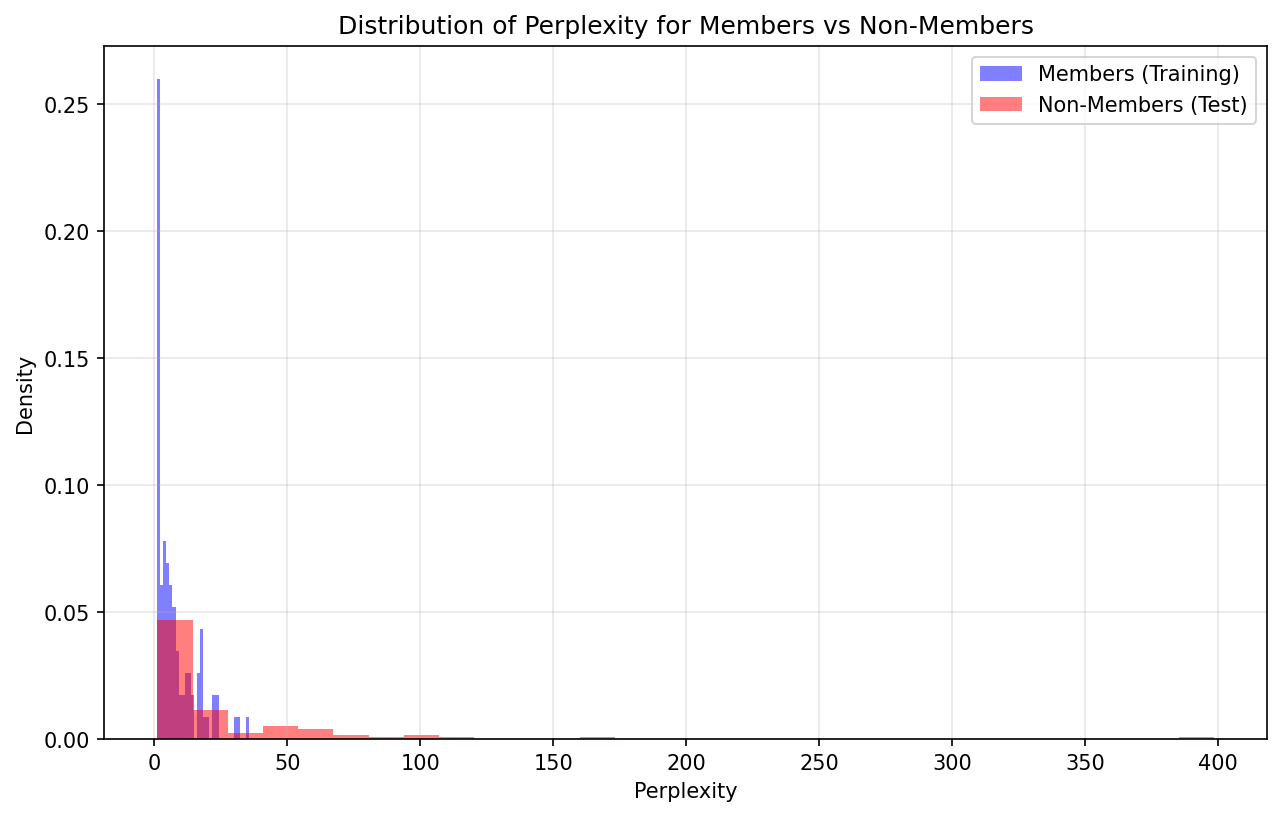

In [ ]:
member_perplexities, member_losses = calculate_perplexity_individual(
    finetuned_model, tokenizer, members
)

non_member_perplexities, non_member_losses = calculate_perplexity_individual(
    finetuned_model, tokenizer, non_members
)

# plot assisted by AI
plt.figure(figsize=(10, 6))
plt.hist(member_perplexities, bins=30, alpha=0.5, label='Members (Training)',
         color='blue', density=True)
plt.hist(non_member_perplexities, bins=30, alpha=0.5, label='Non-Members (Test)',
         color='red', density=True)
plt.xlabel('Perplexity')
plt.ylabel('Density')
plt.title('Distribution of Perplexity for Members vs Non-Members')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#### (c) Plot the ROC curve of the attack by varying the threshold for membership. Report the following metrics: AUC score,  attack accuracy, TPR at 1\% FPR, TPR at 5\% FPR, and TPR at 10\% FPR.

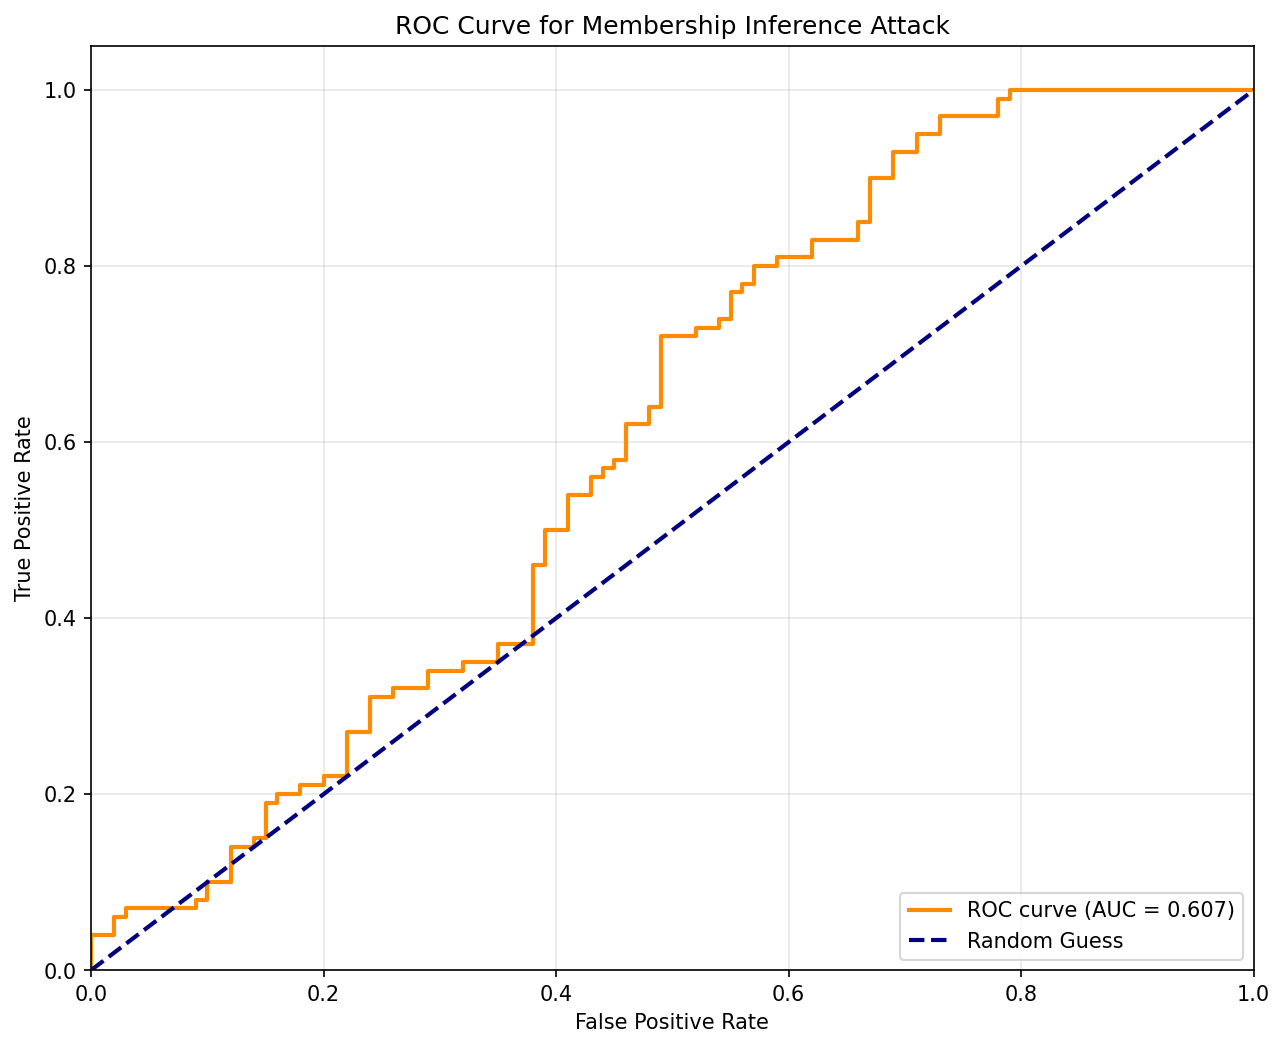

AUC Score: 0.6066
Attack accuracy: 62.00%
TPR at 1% FPR: 0.0000
TPR at 5% FPR: 0.0600
TPR at 10% FPR: 0.0800


In [ ]:
combined_scores = np.concatenate([member_perplexities, non_member_perplexities])
attack_scores_negated = -combined_scores
true_labels = np.concatenate([np.ones(len(member_perplexities)), np.zeros(len(non_member_perplexities))])
fpr, tpr, thresholds = roc_curve(true_labels, attack_scores_negated)
auc_score = auc(fpr, tpr)

def find_tpr_at_fpr(fpr_array, tpr_array, target_fpr):
    idx = np.argmin(np.abs(fpr_array - target_fpr))
    return tpr_array[idx]

tpr_at_1_fpr = find_tpr_at_fpr(fpr, tpr, 0.01)
tpr_at_5_fpr = find_tpr_at_fpr(fpr, tpr, 0.05)
tpr_at_10_fpr = find_tpr_at_fpr(fpr, tpr, 0.10)

best_accuracy = 0
optimal_threshold = 0
for threshold in thresholds:
    predictions = (attack_scores_negated >= threshold).astype(int)
    acc = accuracy_score(true_labels, predictions)
    if acc > best_accuracy:
        best_accuracy = acc
        optimal_threshold = threshold

optimal_predictions = (attack_scores_negated >= optimal_threshold).astype(int)
attack_accuracy = accuracy_score(true_labels, optimal_predictions)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Membership Inference Attack')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

print(f"AUC Score: {auc_score:.4f}")
print(f"Attack accuracy: {attack_accuracy:.2%}")
print(f"TPR at 1% FPR: {tpr_at_1_fpr:.4f}")
print(f"TPR at 5% FPR: {tpr_at_5_fpr:.4f}")
print(f"TPR at 10% FPR: {tpr_at_10_fpr:.4f}")

#### (d) Discuss your observations.
1. The attack achieves AUC of 0.544 and 58% accuracy, which is only slightly better than random guessing. This means measurable but limited memorization of training data.
2. While members show lower average perplexity than non-members, the big overlap in the histogram explains the poor attack performance. That indicates model doesn't perfectly memorize individual samples.
3. With 0% TPR at 1% FPR, the attack fails when high confidence is needed.
